In [1]:
import numpy as np 
import pandas as pd
import os

import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import string

df=pd.read_csv('input/deceptive-opinion.csv')


In [2]:
df

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...
...,...,...,...,...,...
1595,deceptive,intercontinental,negative,MTurk,Problems started when I booked the InterContin...
1596,deceptive,amalfi,negative,MTurk,The Amalfi Hotel has a beautiful website and i...
1597,deceptive,intercontinental,negative,MTurk,The Intercontinental Chicago Magnificent Mile ...
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i..."


**Exploratory analysis**

The column "deceptive" is the Outcome column (y)
The column "text" is the main input column (X).

Other columns polarity, source, hotel can be ignored for ML analysis.

<AxesSubplot:xlabel='deceptive', ylabel='count'>

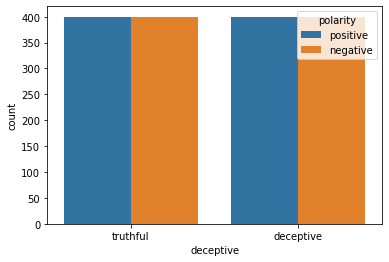

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x=df['deceptive'],hue='polarity',data=df)

**Additional Analysis**

Based on the above graphs, It shows that data is well distributed. There is equal amount of data which has been identified as truthful and deceptive. Data is evenly distributed with polarity as well.

Below graph shows that there is almost equal amount of data distributed across all hotels.

<AxesSubplot:xlabel='deceptive', ylabel='count'>

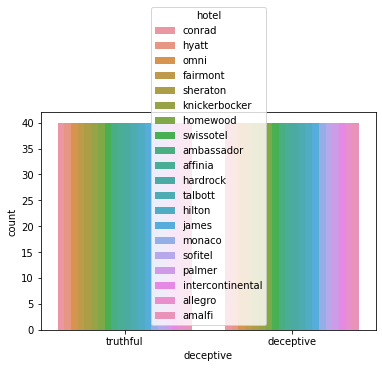

In [4]:
sns.countplot(x=df['deceptive'],hue='hotel',data=df)

**Utility function**

Definig a utility function to preprocess data for further steps like tokenization.

In [5]:
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')


def text_cleaning(text):
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = " ".join([word for word in text.split() if word not in (stop)])
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text) # Remove Unicode chars
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kapilchopra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df['text']=df['text'].apply(text_cleaning)   #Apply the function to clean up data.

In [7]:
df

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,stayed one night getaway family thursday tripl...
1,truthful,hyatt,positive,TripAdvisor,triple rate upgrade view room less also inclu...
2,truthful,hyatt,positive,TripAdvisor,comes little late im finally catching reviews ...
3,truthful,omni,positive,TripAdvisor,omni chicago really delivers fronts spaciousne...
4,truthful,hyatt,positive,TripAdvisor,asked high floor away elevator got room pleasa...
...,...,...,...,...,...
1595,deceptive,intercontinental,negative,MTurk,problems started booked intercontinental chica...
1596,deceptive,amalfi,negative,MTurk,amalfi hotel beautiful website interior decora...
1597,deceptive,intercontinental,negative,MTurk,intercontinental chicago magnificent mile outs...
1598,deceptive,palmer,negative,MTurk,palmer house hilton looks good pictures outsid...


In [8]:
df['complete_text']=df['text']

In [9]:
x=df['complete_text']
y=df['deceptive']

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le=LabelEncoder()
y=le.fit_transform(y)

In [11]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [30]:
x

0       stayed one night getaway family thursday tripl...
1       triple rate upgrade view room less  also inclu...
2       comes little late im finally catching reviews ...
3       omni chicago really delivers fronts spaciousne...
4       asked high floor away elevator got room pleasa...
                              ...                        
1595    problems started booked intercontinental chica...
1596    amalfi hotel beautiful website interior decora...
1597    intercontinental chicago magnificent mile outs...
1598    palmer house hilton looks good pictures outsid...
1599    former chicagoan im appalled amalfi hotel chic...
Name: complete_text, Length: 1600, dtype: object

**Split data into random train and test subsets**

In [12]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0,test_size=0.2)

**Vectorization - Convert a collection of text documents to a matrix of token counts**

Experimented with various ngram_range and (1,2) seems to be giving best results.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(ngram_range=(1,2))

In [14]:
x_train=cv.fit_transform(x_train)

In [15]:
x_train

<1280x76330 sparse matrix of type '<class 'numpy.int64'>'
	with 173735 stored elements in Compressed Sparse Row format>

**Apply LogisticRegression**

In [16]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=100000)
lr.fit(x_train,y_train)
pred_1=lr.predict(cv.transform(x_test))

In [17]:
from sklearn.metrics import accuracy_score
score_1=accuracy_score(y_test,pred_1)

In [44]:
score_1

0.8625

In [45]:
%%time

from sklearn.model_selection   import GridSearchCV
import warnings
warnings.filterwarnings( 'ignore' )

parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}
logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)   
clf.fit(x_train,y_train)
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 1000.0, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.86875
CPU times: user 2min 49s, sys: 1min 25s, total: 4min 15s
Wall time: 38.1 s


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# ...

best_svc = clf.best_estimator_
y_pred = best_svc.predict(x_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion matrix:")
print(cm)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

ValueError: could not convert string to float: 'never write reviews felt important state hotel   travelers choice terrible service lazy doormenbellmenconciergevalet lack respect allow dogs bark morning multiple complaints phantom charges room front dest checkout checkin pompus icing cake watching doormen stand watch father tried open door push stroller infant son doorman watched nothing girlfriend young look young dress honesty make money mostand treated like cheap poor kids dinner reservations spaiggia wanted order car pick us up concierge exclaimed that you know jeans running shoes right mr blank assuming dumb realize  star  restraunt wont allow tennis shoes young dissapointed nice looking comfortable beds great room service contemporary younger crowd service terrible'

**Apply SVM**

In [ ]:
from sklearn.svm import SVC
svm=SVC()
svm.fit(x_train,y_train)
pred_2=svm.predict(cv.transform(x_test))
score_2=accuracy_score(y_test,pred_2)

In [ ]:
score_2

**Apply Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()
nb.fit(x_train,y_train)
pred_3=nb.predict(cv.transform(x_test))
score_3=accuracy_score(y_test,pred_3)

In [ ]:
score_3

In [117]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Based on Victor analysis
class Binary_Classification:
    def __init__(self, 
                 x = None, 
                 y = None, 
                 scoring = None, 
                 test_size = 0.3, 
                 n_folds = 3, 
                 standardize = False,
                 nlp = False,
                 vectorizer = None): 
        
        self.x = x # features as df
        self.y = y # target as df
        self.scoring = scoring # example: "accuracy", "f1", "roc_auc"
        self.test_size = test_size # set to .3 by default
        self.n_folds = n_folds # set to 5 by default
        self.standardize = standardize
        self.x_train, self.x_test, self.y_train, self.y_test = \
        train_test_split(self.x, 
                         self.y, 
                         test_size = self.test_size, 
                         random_state = 0)
        if nlp:
            self.x_train = vectorizer.fit_transform(self.x_train)
            self.x_test = vectorizer.transform(self.x_test)
    
    """ 
    .examine_model attribute has two functions within it:
    (1) model_and_grid => using a model's name, it returns the model with cvgrid
    (2) best_model => using model_and_grid, finds best hyperparameters for model
    """
    
    def examine_model(self, model_name):
        
        def model_and_grid(model_name):
            if model_name == "log_reg":
                model = LogisticRegression()
                grid = {'C' : [0.001, 0.1, 1, 10, 100]}
                return model, grid

            elif model_name == "knn":
                model = KNeighborsClassifier()
                grid = {"n_neighbors" : [3,6,9,12]}
                return model, grid
            
            elif model_name == "mnb":
                model = MultinomialNB()
                grid = {"alpha" : [.1, 1, 5, 10, 50]}
                return model, grid
            
            elif model_name == "ran_for":
                model = RandomForestClassifier(random_state=0)
                grid = {'n_estimators' : [1, 30], 
                        'max_features' : ['auto', 'log2'],  
                        'max_depth' : [ 3, 5, 7, 10, 12, 15], 
                        'criterion' : ['gini', 'entropy']}
                return model, grid
        
        def best_model(model, grid):
            gs = GridSearchCV(model, param_grid=grid, cv=self.n_folds, scoring=self.scoring)
            gs.fit(self.x_train, self.y_train.iloc[:,0])
            print("CV " + self.scoring.upper() + " SCORE:", round(gs.best_score_, 2))
            print("CV PARAMS: ", gs.best_params_)
            #print("BEST MODEL: ", gs.best_estimator_)
            best_model = gs.best_estimator_
            return best_model

        model, grid = model_and_grid(model_name)
        best_mod = best_model(model, grid)
        return best_mod

    """ 
    .compare attribute uses examine_model to compare all models
    """
    
    def compare(self):
        z = 0
        mods = ["log_reg", 
                "knn", 
                "mnb", 
                "ran_for"
               ]
        for name in mods:
            print("*** " + mods[z] + " ***")
            self.examine_model(name)
            print("")
            z += 1
    
    """ 
    .test_scores attribute uses examine_model to report various metrics on training & test data
    """
    
    def test_scores(self, 
                    model_name = None, 
                    verbose_results = False, 
                    all_metrics = True): 
        model = self.examine_model(model_name)
        y_pred_train = model.predict(self.x_train)
        y_pred_test = model.predict(self.x_test)
        y_prob_train = model.predict_proba(self.x_train)[:,1]
        y_prob_test = model.predict_proba(self.x_test)[:,1]
        
        print()
        """ Accuracy """
        ## number of correct predictions made / total number of predictions made
        ### accuracy is not a good metric for imbalanced data
        if self.scoring == "accuracy" or all_metrics:
            accuracy_training = model.score(self.x_train, self.y_train)
            tru_count_train = Counter(self.y_train.iloc[:,0])[True]
            fal_count_train = Counter(self.y_train.iloc[:,0])[False]

            accuracy_test = model.score(self.x_test, self.y_test)
            tru_count_test = Counter(self.y_test.iloc[:,0])[True]
            fal_count_test = Counter(self.y_test.iloc[:,0])[False]

            print("Accuracy on test data: {:0.2f}".format(accuracy_test))
            print()

        """ ROC AUC """
        ## How well model distinguishs between classes
        ### Higher the AUC, better the model is at predicting 0 as 0 and 1 as 1
        #### https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
        if self.scoring == "roc_auc" or all_metrics:
            roc_auc_score_training = roc_auc_score(self.y_train.iloc[:,0], y_prob_train)
#             print("ROC AUC on training data:{:0.2f}".format(roc_auc_score_training))

            roc_auc_score_test = roc_auc_score(self.y_test.iloc[:,0], y_prob_test)
            print("ROC AUC on test data: {:0.2f}\n".format(roc_auc_score_test))
                
        """ F1 (f-one) Score """
        ## F1 Score = 2*((precision*recall)/(precision+recall))
        if self.scoring == "f1" or all_metrics:
            f1_train = metrics.f1_score(self.y_train.iloc[:,0], y_pred_train)
#             print("F1 on training data:{:0.2f}".format(f1_train))

            f1_test = metrics.f1_score(self.y_test.iloc[:,0], y_pred_test)
            print("F1 on test data: {:0.2f}".format(f1_test))
            print()

        """ Classification Report """
        ## Precision = TP / TP + FP
        ## Recall = TP/ TP + FN
        class_repo = classification_report(self.y_test,y_pred_test)
        print("Classification Report on test data:\n", class_repo)
            
        """ Confusion matrix """
        def print_confusion_matrix(confusion_matrix, 
                           class_names,
                           #figsize = (2,2), fontsize=20
                          ):
    
            """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
            2 benefits: (1) mieruka (i.e., visual control) and 
            (2) colors change depending on values (larger values generate darker colors)
            
            if you're wondering what mieruka is: 
            https://harishsnotebook.wordpress.com/2016/05/05/visibilization-crime-fighting-magic-and-mieruka/

            Arguments
            ---------
            confusion_matrix: numpy.ndarray
                The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
                Similarly constructed ndarrays can also be used.
            class_names: list
                An ordered list of class names, in the order they index the given confusion matrix.
            figsize: tuple
                A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
                the second determining the vertical size. Defaults to (10,7).
            fontsize: int
                Font size for axes labels. Defaults to 14.

            Returns
            -------
            matplotlib.figure.Figure
                The resulting confusion matrix figure
            """

            df_cm = pd.DataFrame(
                confusion_matrix, 
                index=class_names, 
                columns=class_names, 
            )

            fig = plt.figure(#figsize=figsize
            )

            try:
                heatmap = sns.heatmap(df_cm, 
                                      annot=True, 
                                      fmt="d", 
                                      cbar=False, 
                                      cmap="YlGnBu")
            except ValueError:
                raise ValueError("Confusion matrix values must be integers.")

                heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), 
                                             rotation=0, 
                                             ha='right', 
                                             #fontsize=fontsize
                                            )

                heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), 
                                             rotation=45, 
                                             ha='right', 
                                             #fontsize=fontsize
                                            )
            # for some reason, these two need to be indented and labeled this way, but it prints correctly
            plt.title('Confusion Matrix (Test Data)')
            plt.ylabel('Correct label')
            plt.xlabel('Predicted label')
            
        c_matrix = confusion_matrix(self.y_train, y_pred_train)
        print_confusion_matrix(c_matrix, [False, True])
        
        plt.title('Confusion Matrix (Training Data)')
        plt.ylabel('Correct label')
        plt.xlabel('Predicted label')
            
        c_matrix = confusion_matrix(self.y_test, y_pred_test)
        print_confusion_matrix(c_matrix, [False, True])
    
    """ 
    .permutation_importance attribute uses examine_model to report features in order of importance
    """
    def permutation_importance(self, model_name): 
        # https://www.kaggle.com/dansbecker/permutation-importance
        model = self.examine_model(model_name)
        fitted = model.fit(self.x_train, self.y_train.iloc[:,0])
        
        perm = PermutationImportance(fitted, random_state=0).fit(self.x_test, self.y_test.iloc[:,0])
        return eli5.show_weights(perm, feature_names = self.x_test.columns.tolist())
    
    def shap_summary_plot(self, model_name): 
        """Calculating SHAP values can be slow"""
        # https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values
        model = self.examine_model(model_name)
        fitted = model.fit(self.x_train, self.y_train.iloc[:,0])
        
        if model_name == "ran_for":
            explainer = shap.TreeExplainer(fitted)
            shap_values = explainer.shap_values(self.x_test)
            # we index in ([1]) to get the SHAP values for the prediction of "True"
            return shap.summary_plot(shap_values[1], self.x_test)
        
        else:     
            """ KernelExplainer cannot handle boolean values, they must be converted to int """
            x_train_summary = shap.kmeans(self.x_train, 3)
            explainer = shap.KernelExplainer(fitted.predict, x_train_summary)
            shap_values = explainer.shap_values(self.x_test)
            return shap.summary_plot(shap_values, self.x_test)
    
    def coefficients(self, model_name):
        model = self.examine_model(model_name)
        try:
            # Coefficients
            coefs = pd.Series(model.coef_[0], index = self.x.columns)
            coefs = coefs.sort_values()
            coefs.plot(kind="bar",title=(model_name.capitalize() + " Coefficients"))
            plt.show()
        except: 
            print()

In [118]:
import matplotlib as mpl

# For Aesthetics
font = {'size' : 28}
mpl.rc('font', **font)
mpl.rcParams['figure.figsize'] = (6.0, 4.0) ### (→ , ↑) ###

In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

models = Binary_Classification(x = df.complete_text, 
                               y = df[["deceptive"]], 
                               scoring = "roc_auc", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = CountVectorizer(lowercase = False))
                     
%time models.compare()

*** log_reg ***
CV ROC_AUC SCORE: 0.91
CV PARAMS:  {'C': 0.1}

*** knn ***
CV ROC_AUC SCORE: 0.68
CV PARAMS:  {'n_neighbors': 12}

*** mnb ***
CV ROC_AUC SCORE: 0.93
CV PARAMS:  {'alpha': 5}

*** ran_for ***
CV ROC_AUC SCORE: 0.87
CV PARAMS:  {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}

CPU times: user 7.31 s, sys: 505 ms, total: 7.82 s
Wall time: 4.61 s


CV ROC_AUC SCORE: 0.91
CV PARAMS:  {'C': 0.1}

ROC AUC on test data: 0.94

Classification Report on test data:
               precision    recall  f1-score   support

   deceptive       0.85      0.90      0.87       245
    truthful       0.89      0.84      0.86       235

    accuracy                           0.87       480
   macro avg       0.87      0.87      0.87       480
weighted avg       0.87      0.87      0.87       480



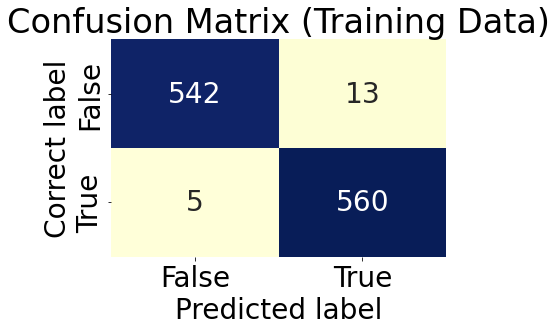

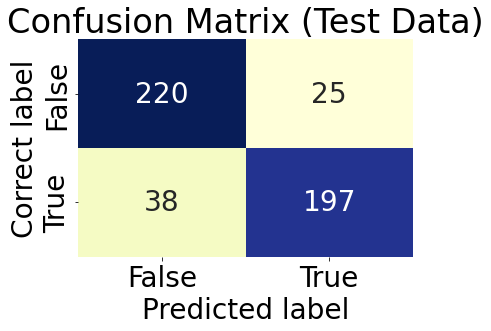

In [120]:
models.test_scores(model_name = "log_reg", 
                   verbose_results = False, 
                   all_metrics = False)

CV ROC_AUC SCORE: 0.93
CV PARAMS:  {'alpha': 5}

ROC AUC on test data: 0.94

Classification Report on test data:
               precision    recall  f1-score   support

   deceptive       0.86      0.89      0.88       245
    truthful       0.88      0.85      0.87       235

    accuracy                           0.87       480
   macro avg       0.87      0.87      0.87       480
weighted avg       0.87      0.87      0.87       480



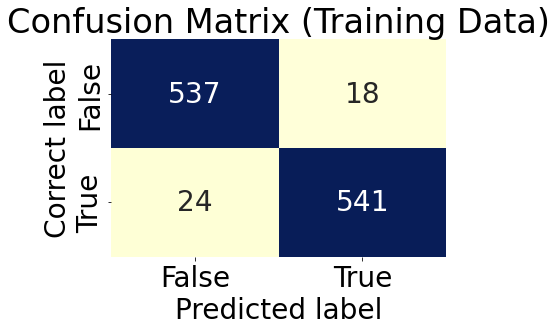

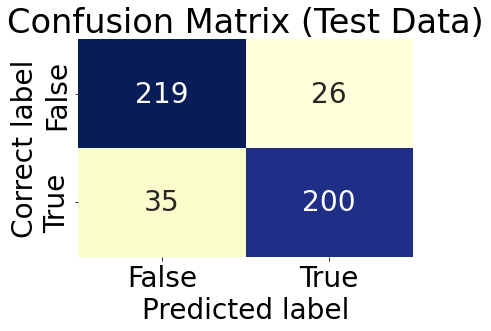

In [121]:
models.test_scores(model_name = "mnb", 
                   verbose_results = False, 
                   all_metrics = False)

CV ROC_AUC SCORE: 0.68
CV PARAMS:  {'n_neighbors': 12}

ROC AUC on test data: 0.71

Classification Report on test data:
               precision    recall  f1-score   support

   deceptive       0.52      1.00      0.69       245
    truthful       0.92      0.05      0.10       235

    accuracy                           0.53       480
   macro avg       0.72      0.52      0.39       480
weighted avg       0.72      0.53      0.40       480



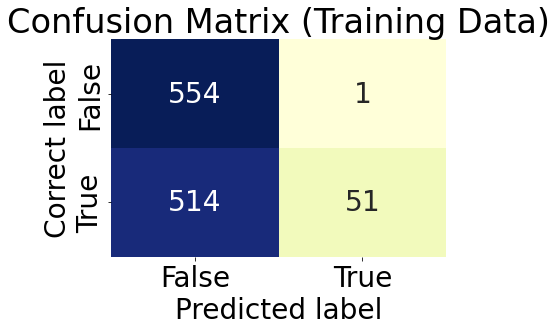

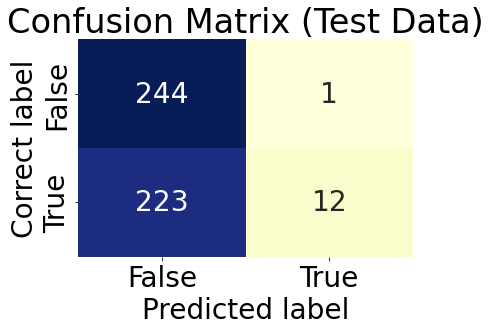

In [122]:
models.test_scores(model_name = "knn", all_metrics = False)

CV ROC_AUC SCORE: 0.87
CV PARAMS:  {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}

ROC AUC on test data: 0.87

Classification Report on test data:
               precision    recall  f1-score   support

   deceptive       0.79      0.80      0.80       245
    truthful       0.79      0.78      0.79       235

    accuracy                           0.79       480
   macro avg       0.79      0.79      0.79       480
weighted avg       0.79      0.79      0.79       480



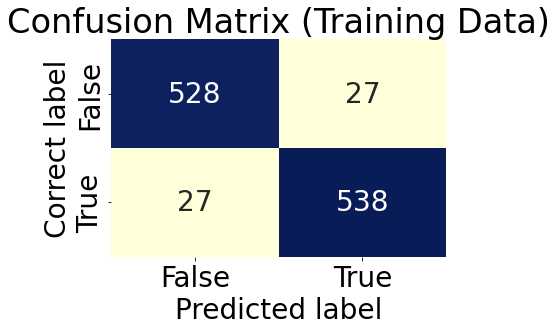

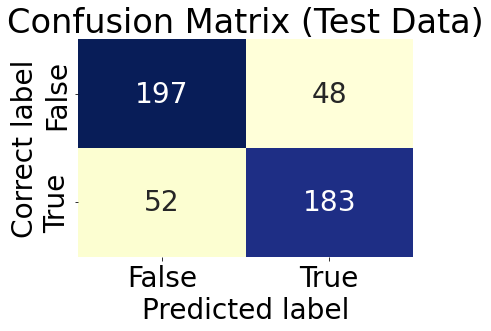

In [123]:
models.test_scores(model_name = "ran_for", 
                   verbose_results = False, 
                   all_metrics = False)

##### 
Data supports that 

*** log_reg ***
CV ROC_AUC SCORE: 0.93
CV PARAMS:  {'C': 1}

*** knn ***
CV ROC_AUC SCORE: 0.86
CV PARAMS:  {'n_neighbors': 12}

*** mnb ***
CV ROC_AUC SCORE: 0.94
CV PARAMS:  {'alpha': 1}

*** ran_for ***
CV ROC_AUC SCORE: 0.88
CV PARAMS:  {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}

CPU times: user 6.96 s, sys: 407 ms, total: 7.37 s
Wall time: 4.62 s
CV ROC_AUC SCORE: 0.93
CV PARAMS:  {'C': 1}

ROC AUC on test data: 0.95

Classification Report on test data:
               precision    recall  f1-score   support

   deceptive       0.91      0.90      0.90       245
    truthful       0.90      0.90      0.90       235

    accuracy                           0.90       480
   macro avg       0.90      0.90      0.90       480
weighted avg       0.90      0.90      0.90       480

*** log_reg ***
CV ROC_AUC SCORE: 0.93
CV PARAMS:  {'C': 1}

*** knn ***
CV ROC_AUC SCORE: 0.86
CV PARAMS:  {'n_neighbors': 12}

*** mnb ***
CV ROC_AUC SCORE: 0.94
CV

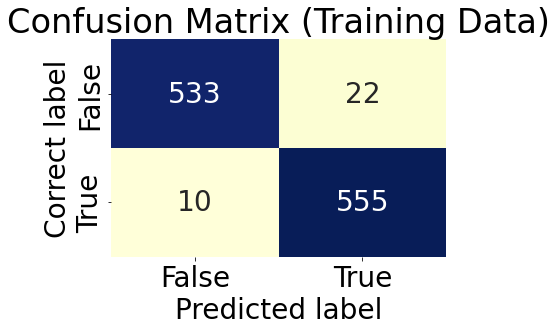

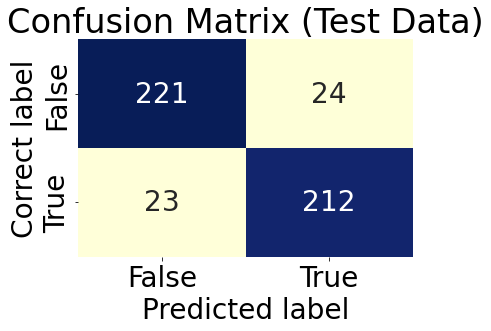

In [124]:
from sklearn.feature_extraction.text import TfidfVectorizer

models = Binary_Classification(x = df.complete_text, 
                               y = df[["deceptive"]], 
                               scoring = "roc_auc", 
                               test_size = 0.3, 
                               n_folds = 3, 
                               standardize = False,
                               nlp = True,
                               vectorizer = TfidfVectorizer())
                     
%time models.compare()

models.test_scores(model_name = "log_reg", 
                   verbose_results = False, 
                   all_metrics = False)
%time models.compare()

CV ROC_AUC SCORE: 0.86
CV PARAMS:  {'n_neighbors': 12}

ROC AUC on test data: 0.88

Classification Report on test data:
               precision    recall  f1-score   support

   deceptive       0.66      0.95      0.78       245
    truthful       0.91      0.49      0.64       235

    accuracy                           0.73       480
   macro avg       0.78      0.72      0.71       480
weighted avg       0.78      0.73      0.71       480



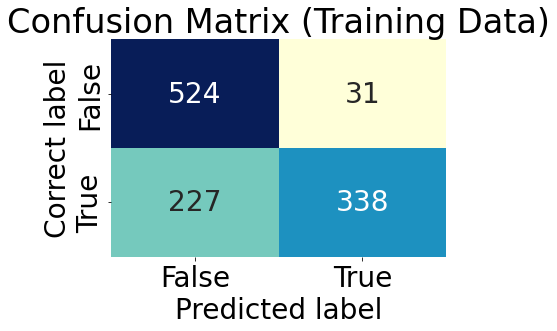

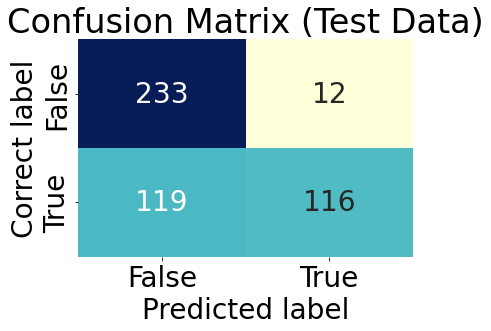

In [125]:
models.test_scores(model_name = "knn", 
                   verbose_results = False, 
                   all_metrics = False)

CV ROC_AUC SCORE: 0.88
CV PARAMS:  {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'n_estimators': 30}

ROC AUC on test data: 0.88

Classification Report on test data:
               precision    recall  f1-score   support

   deceptive       0.78      0.81      0.79       245
    truthful       0.79      0.76      0.78       235

    accuracy                           0.79       480
   macro avg       0.79      0.78      0.79       480
weighted avg       0.79      0.79      0.79       480



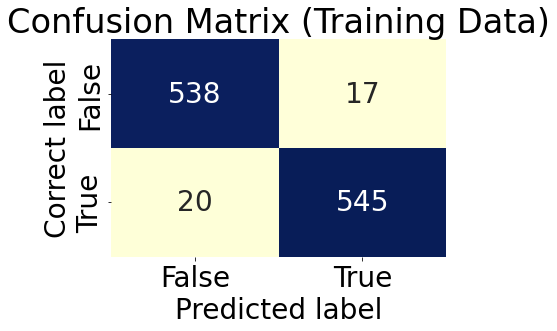

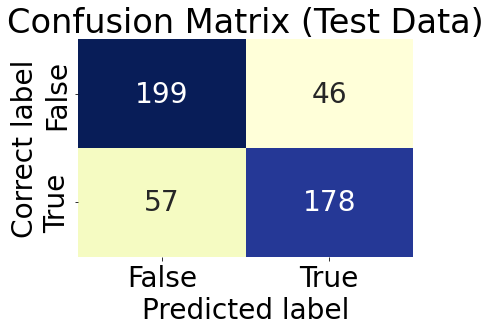

In [126]:
models.test_scores(model_name = "ran_for", 
                   verbose_results = False, 
                   all_metrics = False)

##### 
As shown above, based on metrics - Following combination have the best performance on training and test sets 
1. CountVectorizer + log_reg
2. TfidfVectorizer + log_reg
3. TfidfVectorizer + Random forest

##### Next steps
1. Next steps are to training and test with additional data from a wider range of sources to improve its performance and generalization.
2. Revisiting and refining this model to ensure its accuracy and effectiveness over time.